# Истинная орбита МКС - фильтр Калмана

## Импорт Необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

## Функции

In [3]:
def FuncOrbite(t, x): # Функция f(x, t)
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    v = np.copy(x[3:])
    second_order = (np.array([r[0]*r[2]**2, r[1]*r[2]**2, r[2]**3]) * 15 / r_abs**7 -
                    np.array([3*r[0], 3*r[1], 9*r[2]]) / r_abs**5) * mu * J2 * R**2 / 2 
    return np.concatenate((v, -mu * r / r_abs**3 + second_order), axis=0)

def FuncMeasure(x): # Функция h(x)
    return x

def ModelError(t): # Функция шума модели состояния. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return np.append(Ampl_w_r * rng.random(3), Ampl_w_v * rng.random(3))

def MeasureError(t): # Функция шума модели наблюдения. Функция может быть любой, но ограниченной
    rng = np.random.default_rng()
    return np.append(Ampl_v_r * rng.random(3), Ampl_v_v * rng.random(3))

def JacobianF(x):
    r = np.copy(x[:3])
    r_abs = np.linalg.norm(r)
    Phi = np.zeros((6,6))
    Phi[0:3, 3:6] = np.eye(3)
    a = mu * J2 * R**2 / 2 * (15 * r[2]**2 / r_abs**7 - 3 / r_abs**5)
    b = 15 * mu * J2 * R**2 / r_abs**7 * r[2]
    Phi[3, 0] = -mu / r_abs**3 + a
    Phi[4, 1] = -mu / r_abs**3 + a
    Phi[5, 2] = -mu / r_abs**3 + 3*a
    Phi[3, 2] = b * r[0]
    Phi[4, 2] = b * r[1]
    return Phi

def JacobianH(x):
    return np.eye(6)

def time(str_t):
    A = str_t.split(':')
    for i in range(len(A)):
        if A[i][0:2] == '00':
            if len(A[i]) <= 2:
                A[i] = '0'
            else:
                A[i] = '0' + A[i][2:]
    return int(A[0]) * 3600 + int(A[1]) * 60 + float(A[2])

## Расширенный фильтр Калмана

### Предиктор

In [103]:
def predictorStatus(xk_1, tk_1, tk):
    dt = tk - tk_1
    xk_estimated = xk_1 + FuncOrbite(tk, xk_1) * dt
    return xk_estimated

def predictorCovar(Pk_1, xk_1, tk_1, tk):
    dt = tk - tk_1
    Phi = np.eye(6) + JacobianF(xk_1) * dt
    wk = ModelError(tk_1)
    Q = np.diag(wk**2) # Матрица ковариаций шумов модели
    Pk_estimated = Phi @ Pk_1 @ Phi.T + Q
    return Pk_estimated

### Корректор

In [119]:
def MatrixK(Pk_estimated, xk_estimated, tk):
    vk = MeasureError(tk)
    R = np.diag(vk**2) # Матрица ковариаций шумов модели
    H = JacobianH(xk_estimated)
    
    pk_norm = norm(Pk_estimated @ H.T) # Норма произведения первых двух матриц
    sm_norm = norm(H @ Pk_estimated @ H.T + R) # Second Matrix Norm (норма матрицы, от которой берётся обратная)
    A = Pk_estimated @ H.T / pk_norm # Нормированная первая часть
    B = H @ Pk_estimated @ H.T + R / sm_norm # Нормированная вторая часть
    # K = pk_norm / sm_norm * (A @ B^(-1))
    
    if np.linalg.det(B) != 0:
        #K = pk_norm / sm_norm * (A @ np.linalg.inv(B))
        K = Pk_estimated @ H.T @ np.linalg.inv(H @ Pk_estimated @ H.T + R)
    else:
        K = np.eye(6)
    return K

def correctorStatus(xk_estimated, zk, K):
    xk = xk_estimated + K @ (zk - FuncMeasure(xk_estimated))
    return xk

def correctorCovar(Pk_estimated, xk, K):
    Pk = (np.eye(6) - K @ JacobianH(xk)) @ Pk_estimated
    return Pk

## Параметры

In [163]:
mu = 3.986004418e5
J2 = 0.0010827
R = 6378.137

# Параметры для w(t) - погрешности модели:
Ampl_w_r = 1e-2
Ampl_w_v = 1e-5

# Параметры для v(t) - погрешности измерения:
Ampl_v_r = 1e-2
Ampl_v_v = 1e-5

## Рабочая область

In [173]:
data = pd.read_csv("iss_test.txt", delim_whitespace=True)
N = len(data.iloc[:,0])
x = np.array(data.iloc[0, 1:])
P = np.diag([Ampl_w_r, Ampl_w_r, Ampl_w_r, Ampl_w_v, Ampl_w_v, Ampl_w_v])
status = data.copy(deep=True)
for i in range(1, data.shape[0]):
    t_curr = time(data.iloc[i, 0])
    t_prev = time(data.iloc[i-1, 0])
    x_est = predictorStatus(x, t_prev, t_curr)
    #x = x_est
    P_est = predictorCovar(P, x, t_prev, t_curr)
    #print(np.linalg.norm(P_est))
    #P = P_est
    K = MatrixK(P_est, x_est, t_curr)
    z = np.array(data.iloc[i, 1:]) + MeasureError(t_curr)
    x = correctorStatus(x_est, z, K)
    P = correctorCovar(P_est, x, K)
    status.iloc[i, 1:] = x
    #if norm(z[0:3] - x_est[0:3]) > 100:
    #    print("# iteration: ", i)
    #    print("x_est = ", x_est)
    #    print("z = ", z)
    #    print("x = ", x)
    #    print("P_est (norm) = ", norm(P_est))
    #    print("P (norm) = ", norm(P))
    #    print("K (norm) = ", norm(K))
    #    print("====================")
    
# Поиск максимальной ошибки
max_coord = 0
max_velos = 0
for i in range(N):
    if norm(status.iloc[i, 1:4] - data.iloc[i, 1:4]) > max_coord:
        max_coord = norm(status.iloc[i, 1:4] - data.iloc[i, 1:4])
    if norm(status.iloc[i, 4:] - data.iloc[i, 4:]) > max_velos:
        max_velos = norm(status.iloc[i, 4:] - data.iloc[i, 4:])

## Отображение результатов:

Y-coordinate from time:
1  Jan  2000       0.000000
        2000       4.721456
        2000       9.431641
        2000      14.146860
        2000      18.862052
                   ...     
        2000    1902.120353
        2000    1906.313356
        2000    1910.510243
        2000    1914.704484
        2000    1918.893538
Name: DefaultSC.EarthMJ2000Eq.Y, Length: 6001, dtype: float64


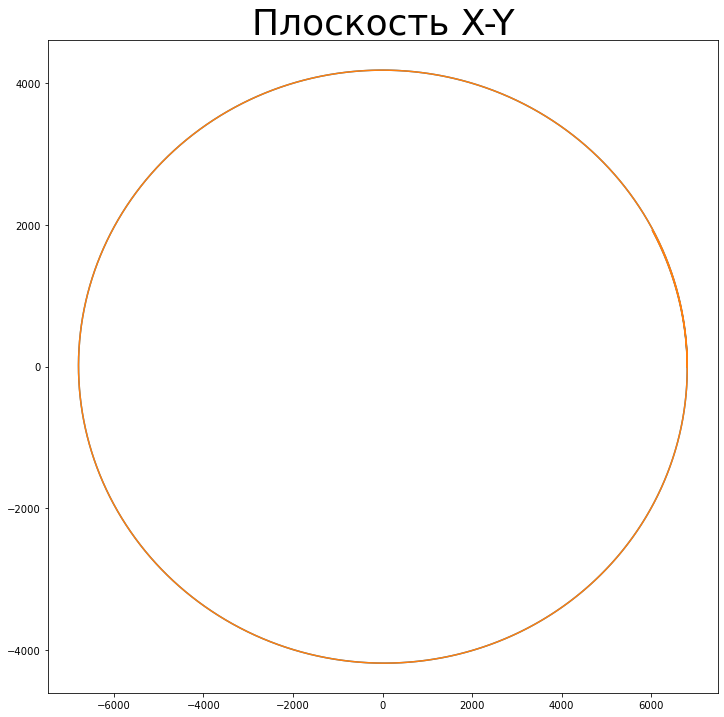

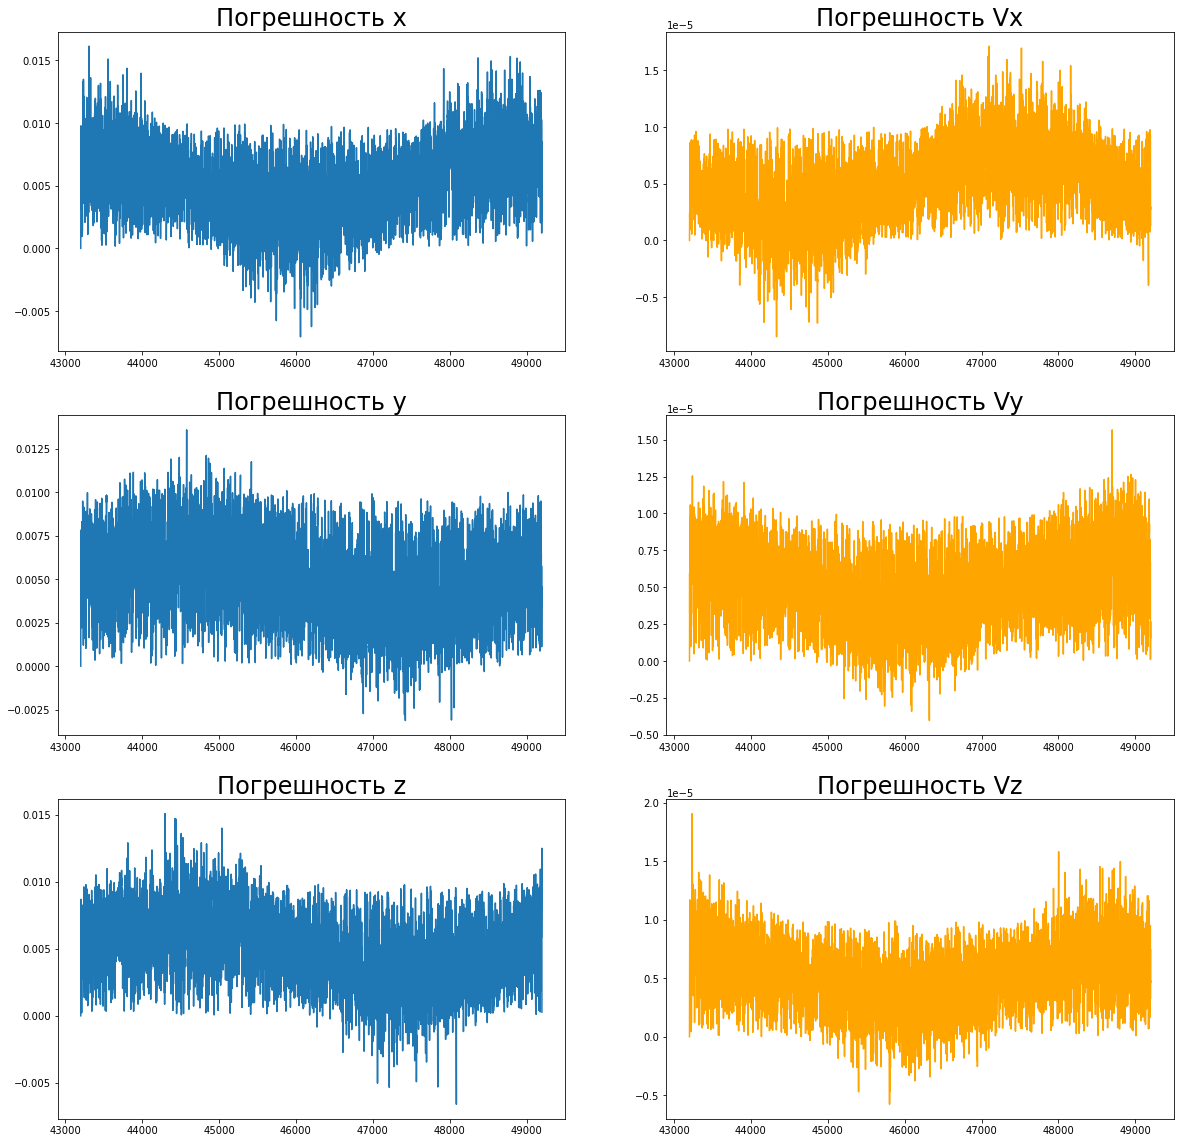

Максимальная ошибка по координате:  0.019093315181898163
Максимальная ошибка по скорости:  2.2598675897269353e-05


In [174]:
print("Y-coordinate from time:")
print(status.iloc[:, 2])

fig_XY, ax_XY = plt.subplots(figsize=(12, 12))
ax_XY.plot(status.iloc[:, 1], status.iloc[:, 2], label="Состояние")
ax_XY.plot(data.iloc[:, 1], data.iloc[:, 2], label="Измерение")
ax_XY.set_title("Плоскость X-Y", size=36)
fig_XY.legend

fig, ax = plt.subplots(3, 2, figsize=(20, 20))
Timeline = list(map(time, data.iloc[:, 0]))
ax[0][0].plot(Timeline, status.iloc[:, 1]-data.iloc[:, 1])
ax[1][0].plot(Timeline, status.iloc[:, 2]-data.iloc[:, 2])
ax[2][0].plot(Timeline, status.iloc[:, 3]-data.iloc[:, 3])
ax[0][1].plot(Timeline, status.iloc[:, 4]-data.iloc[:, 4], "orange")
ax[1][1].plot(Timeline, status.iloc[:, 5]-data.iloc[:, 5], "orange")
ax[2][1].plot(Timeline, status.iloc[:, 6]-data.iloc[:, 6], "orange")
ax[0][0].set_title("Погрешность x", size=24)
ax[1][0].set_title("Погрешность y", size=24)
ax[2][0].set_title("Погрешность z", size=24)
ax[0][1].set_title("Погрешность Vx", size=24)
ax[1][1].set_title("Погрешность Vy", size=24)
ax[2][1].set_title("Погрешность Vz", size=24)

plt.show()

print("Максимальная ошибка по координате: ", max_coord)
print("Максимальная ошибка по скорости: ", max_velos)